In [1]:
!pip install shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

In [3]:
train_df = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv")
test_df = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/test.csv")

# Examining properties of data

In [4]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
# check for null values
print(train_df.isnull().values.any())

False


In [6]:
# check distribution of values for each future
def plot_dist_find_range(df, col_name):
  plt.hist(df[col_name])
  plt.xlabel(col_name)
  plt.ylabel("Count")
  plt.title("Distribution of " + col_name)
  plt.show
  return [df[col_name].min(), df[col_name].max()]

[-5, 133]


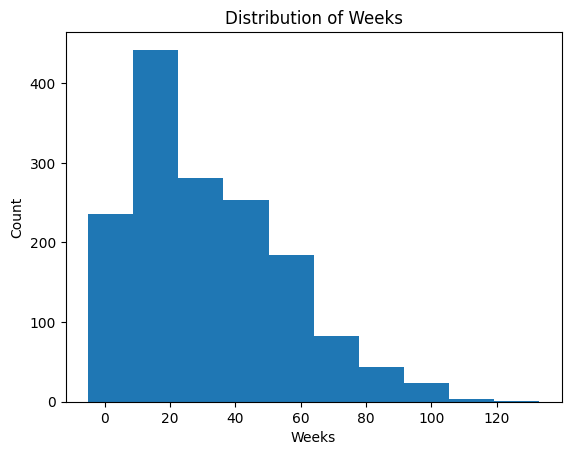

In [7]:
feat_range = plot_dist_find_range(train_df, "Weeks")
print(feat_range)

[827, 6399]


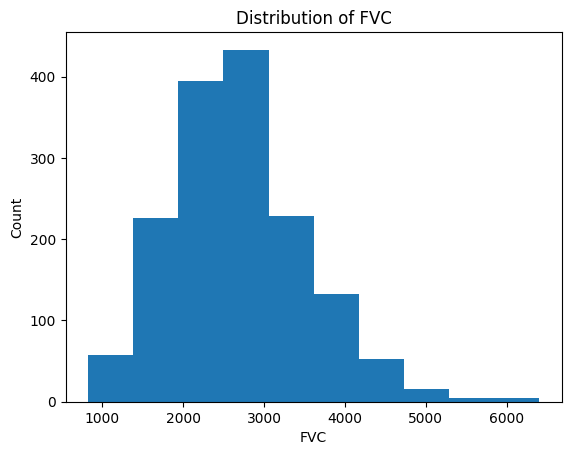

In [8]:
feat_range = plot_dist_find_range(train_df, "FVC")
print(feat_range)

[28.8775766716943, 153.145377828922]


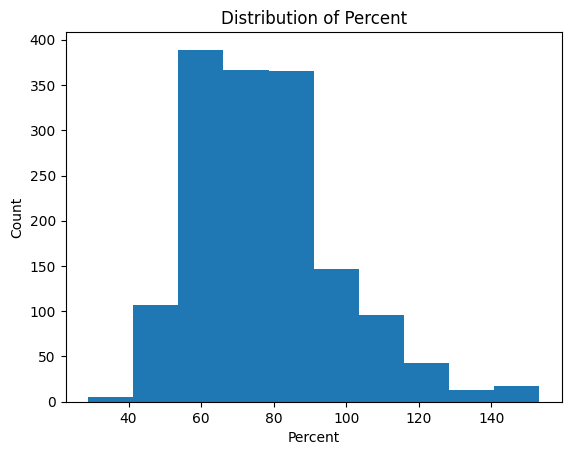

In [9]:
feat_range = plot_dist_find_range(train_df, "Percent")
print(feat_range)

[49, 88]


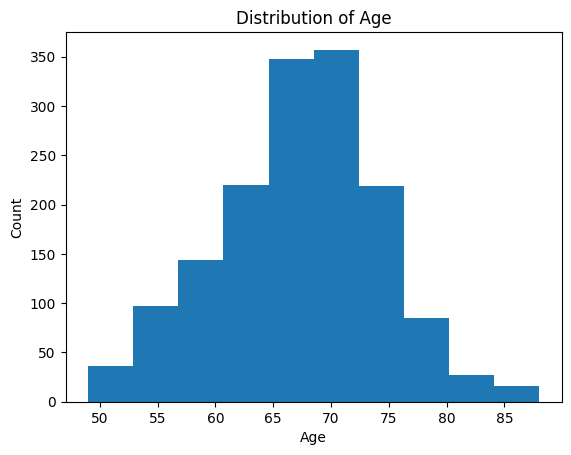

In [10]:
feat_range = plot_dist_find_range(train_df, "Age")
print(feat_range)

['Female', 'Male']

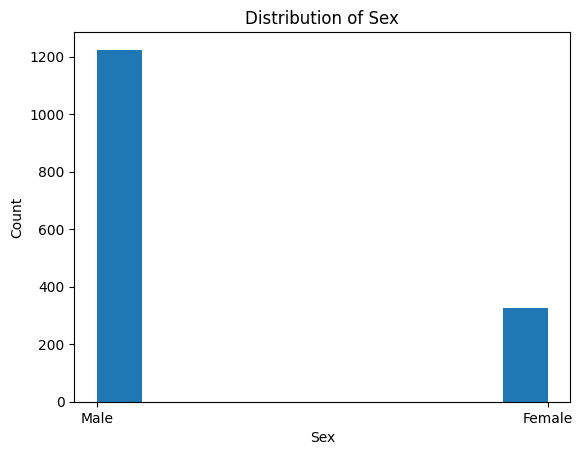

In [11]:
# categorical variable, range doesn't apply
plot_dist_find_range(train_df, "Sex")

['Currently smokes', 'Never smoked']

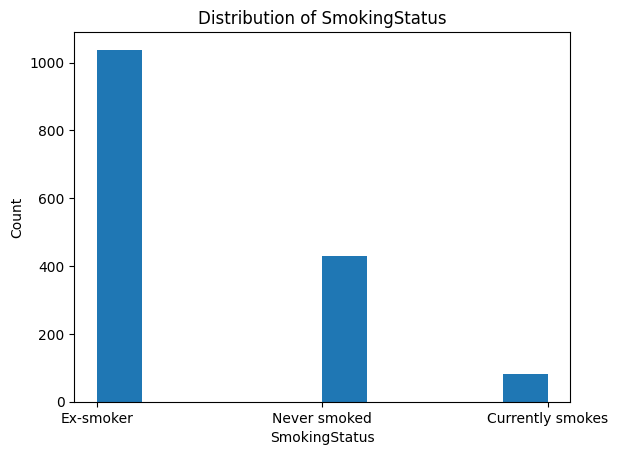

In [12]:
# categorical variable, range doesn't apply
plot_dist_find_range(train_df, "SmokingStatus")

# Implementing ADS

In [13]:
# extra installs needed for my environment
!pip install opencv-python-headless
!pip install pydicom
!pip install tensorflow_addons
!pip install scikit-image

In [14]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /Users/nisha/Desktop/spring2024/ResponsibleDataScience/final_project/input/kerasapplications/keras-team-keras-applications-3b180cb
  Preparing metadata (setup.py) ... done
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50699 sha256=1398b561b9a27161c75af990f4862c86a3b5709d4699949d76c4fad3b9fb0371
  Stored in directory: /Users/nisha/Library/Caches/pip/wheels/80/48/b4/7e79037092df15f6942998d6334fbb8e059d25a4a7cbed6333
Successfully built Keras-Applications
  Attempting uninstall: Keras-Applications
    Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
Looking in links: ./
Processing /Users/nisha/Desktop/spring2024/ResponsibleDataScience/final_project/input/efficientnet/efficientnet-1.1.0
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl siz

In [15]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

/Users/nisha/miniforge3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [17]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')

Linear Decay (based on EfficientNets)

In [18]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30]

    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)

    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

In [19]:
A = {}
TAB = {}
P = []
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :]
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]

    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

0it [00:00, ?it/s]

CNN for coeff prediction

In [20]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [21]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size

        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        x = []
        a, tab = [], []
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)

        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [22]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D,
    LeakyReLU, Concatenate
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2])
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)

    weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    model.load_weights('../input/effnet-b5-30epochs-1/effnet_30.h5')
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

Number of models: 1


In [23]:
from sklearn.model_selection import train_test_split

tr_p, vl_p = train_test_split(P,
                              shuffle=True,
                              train_size= 1)

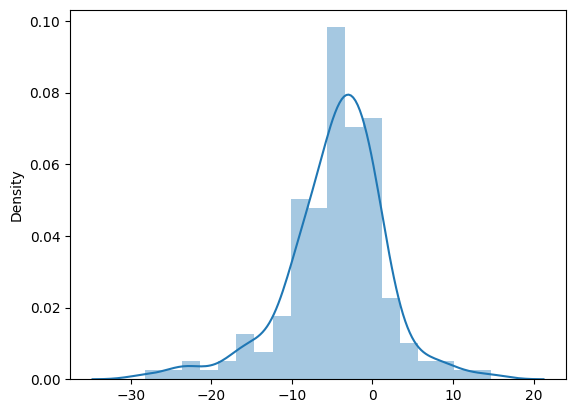

In [24]:
sns.distplot(list(A.values()));

In [25]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70) # changed from 70, trie 66.7 too
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [ ]:
subs = []
for model in models:

    q = 0.5

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 1.1 and int(i[:-4]) / len(ldir) > -0.1:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

 3/15 [=====>........................] - ETA: 2:06


Averaging Predictions¶


In [ ]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [ ]:
sub.head()

In [ ]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [ ]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

Osic-Multiple-Quantile-Regression

In [ ]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

In [ ]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = pd.concat([tr, chunk, sub])

In [ ]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

In [ ]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [ ]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [ ]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [ ]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [ ]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
#data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','week','BASE']

In [ ]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [ ]:
tr.shape, chunk.shape, sub.shape

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    # tf.dtypes.cast(y_true, tf.float32)
    # tf.dtypes.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    # sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    sq2 = tf.sqrt(tf.cast(2, dtype=tf.float32))
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    # model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False), metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False), metrics=[score])

    return model

In [ ]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [ ]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

In [ ]:
NFOLD = 2 # originally 5
kf = KFold(n_splits=NFOLD)

In [ ]:
def check_finite(data, label):
    if not np.isfinite(data).all():
        print(f"Non-finite found in {label}")

In [ ]:
%%time
cnt = 0
EPOCHS = 600
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

In [ ]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

In [ ]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [ ]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

In [ ]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [ ]:
sub.head()

In [ ]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

In [ ]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
sigma_mean = 60
if sigma_mean<sigma_mean:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [ ]:
subm.head()

In [ ]:
subm.describe().T

In [ ]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [ ]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

Ensemble (Simple Blend)

In [ ]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [ ]:
df = df1[['Patient_Week']].copy()
df['FVC'] = (0.45*df1['FVC'] + 0.55*df2['FVC'])
df['Confidence'] = (0.45*df1['Confidence'] + 0.55*df2['Confidence'])
df.head()

In [ ]:
df.to_csv('submission.csv', index=False)

# Evaluating performance of original ADS

In [ ]:
submission_df = pd.read_csv("submission.csv")
submission_df['Patient'] = submission_df['Patient_Week'].apply(lambda x: x.split('_')[0])
submission_df['Weeks'] = submission_df['Patient_Week'].apply(lambda x: int(x.split('_')[1]))
print(submission_df.head())

In [ ]:
combined_df = pd.concat([train_df, test_df], axis=0)
print(combined_df.head())

In [ ]:
merged_df = pd.merge(submission_df, combined_df, on=['Patient', 'Weeks'], suffixes=('_pred', '_actual'))
print(merged_df.head())

In [ ]:
# note the significant loss in data when creating merged_df
# due to lack of rows where patient/week in submission.csv matches patient/week in train/test.csv
print("Number of rows in submission.csv:", len(submission_df.index))
print("Number of rows in train.csv & test.csv:", len(combined_df.index))
print("Number of rows in merged_df:", len(merged_df.index))

In [ ]:
# calculate accuracy metrics
mae = mean_absolute_error(merged_df['FVC_actual'], merged_df['FVC_pred'])
rmse = mean_squared_error(merged_df['FVC_actual'], merged_df['FVC_pred'], squared=False)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

In [ ]:
# functions for fairness metrics
def mean_prediction_bias(data, group_column):
    bias = {}
    for group in data[group_column].unique():
        subgroup_data = data[data[group_column] == group]
        actual_mean = subgroup_data['FVC_actual'].mean()
        predicted_mean = subgroup_data['FVC_pred'].mean()
        bias[group] = predicted_mean - actual_mean
    return bias

def coefficient_of_variation_ratio(data, group_column):
    cvr = {}
    groups = data[group_column].unique()
    group_cvs = {group: data[data[group_column] == group]['FVC_pred'].std() / data[data[group_column] == group]['FVC_pred'].mean() for group in groups}
    base_cv = group_cvs[next(iter(groups))]  # use the first group as a reference
    for group, cv in group_cvs.items():
        cvr[group] = cv / base_cv
    return cvr

In [ ]:
# calculate fairness metrics by gender
bias_by_sex = mean_prediction_bias(merged_df, 'Sex')
cvr_by_sex = coefficient_of_variation_ratio(merged_df, 'Sex')

print(bias_by_sex)
print(cvr_by_sex)

# no instances of females in merged_df :(
print("Female count in merged data:", merged_df[merged_df['Sex'] == 'Female'].shape[0])
print("Male count in merged data:", merged_df[merged_df['Sex'] == 'Male'].shape[0])

In [ ]:
# calculate fairness metrics by age

age_bins = [0, 50, 60, 70, 100]
age_labels = ['<50', '50-60', '60-70', '70+']
merged_df['AgeGroup'] = pd.cut(merged_df['Age'], bins=age_bins, labels=age_labels, right=False)

bias_by_age = mean_prediction_bias(merged_df, 'AgeGroup')
cvr_by_age = coefficient_of_variation_ratio(merged_df, 'AgeGroup')

print(bias_by_age)
print(cvr_by_age)

# no instances of age < 60 in merged_df :(
print("<50 count in merged data:", merged_df[merged_df['AgeGroup'] == '<50'].shape[0])
print("50-60 count in merged data:", merged_df[merged_df['AgeGroup'] == '50-60'].shape[0])
print("60-70 count in merged data:", merged_df[merged_df['AgeGroup'] == '60-70'].shape[0])
print("70+ count in merged data:", merged_df[merged_df['AgeGroup'] == '70+'].shape[0])

In [ ]:
# additional methods for analyzing performance of ADS
  # assess stability & robustness by analyzing variations in performance metrics across different random seeds
def run_diff_seeds(seed):
    # seed everything for reproducibility
    seed_everything(seed)

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    
    train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')

    A = {}
    TAB = {}
    P = []
    for i, p in tqdm(enumerate(train.Patient.unique())):
        sub = train.loc[train.Patient == p, :]
        fvc = sub.FVC.values
        weeks = sub.Weeks.values
        c = np.vstack([weeks, np.ones(len(weeks))]).T
        a, b = np.linalg.lstsq(c, fvc)[0]
    
        A[p] = a
        TAB[p] = get_tab(sub)
        P.append(p)

    class IGenerator(Sequence):
        BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
        def __init__(self, keys, a, tab, batch_size=32):
            self.keys = [k for k in keys if k not in self.BAD_ID]
            self.a = a
            self.tab = tab
            self.batch_size = batch_size
    
            self.train_data = {}
            for p in train.Patient.values:
                self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
        def __len__(self):
            return 1000
    
        def __getitem__(self, idx):
            x = []
            a, tab = [], []
            keys = np.random.choice(self.keys, size = self.batch_size)
            for k in keys:
                try:
                    i = np.random.choice(self.train_data[k], size=1)[0]
                    img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                    x.append(img)
                    a.append(self.a[k])
                    tab.append(self.tab[k])
                except:
                    print(k, i)
    
            x,a,tab = np.array(x), np.array(a), np.array(tab)
            x = np.expand_dims(x, axis=-1)
            return [x, tab] , a

    model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
    models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
    print('Number of models: ' + str(len(models)))
    
    tr_p, vl_p = train_test_split(P,
                                  shuffle=True,
                                  train_size= 1)

    sns.distplot(list(A.values()))

    subs = []
    for model in models:
    
        q = 0.5
    
        sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
        test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
        A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
        STD, WEEK = {}, {} 
        for p in test.Patient.unique():
            x = [] 
            tab = [] 
            ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 1.1 and int(i[:-4]) / len(ldir) > -0.1:
                    x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                    tab.append(get_tab(test.loc[test.Patient == p, :])) 
            if len(x) <= 1:
                continue
            tab = np.array(tab) 
    
            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q)
            A_test[p] = a
            B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
            P_test[p] = test.Percent.values[test.Patient == p] 
            WEEK[p] = test.Weeks.values[test.Patient == p]
    
        for k in sub.Patient_Week.values:
            p, w = k.split('_')
            w = int(w) 
    
            fvc = A_test[p] * w + B_test[p]
            sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
            sub.loc[sub.Patient_Week == k, 'Confidence'] = (
                P_test[p] - A_test[p] * abs(WEEK[p] - w) 
        ) 
    
        _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
        subs.append(_sub)
    
    N = len(subs)
    sub = subs[0].copy() # ref
    sub["FVC"] = 0
    sub["Confidence"] = 0
    for i in range(N):
        sub["FVC"] += subs[0]["FVC"] * (1/N)
        sub["Confidence"] += subs[0]["Confidence"] * (1/N)

    sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

    img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

    ROOT = "../input/osic-pulmonary-fibrosis-progression"
    BATCH_SIZE=128
    
    tr = pd.read_csv(f"{ROOT}/train.csv")
    tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
    chunk = pd.read_csv(f"{ROOT}/test.csv")
    
    print("add infos")
    sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
    sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
    sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
    sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
    sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

    tr['WHERE'] = 'train'
    chunk['WHERE'] = 'val'
    sub['WHERE'] = 'test'
    data = pd.concat([tr, chunk, sub])

    data['min_week'] = data['Weeks']
    data.loc[data.WHERE=='test','min_week'] = np.nan
    data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

    base = data.loc[data.Weeks == data.min_week]
    base = base[['Patient','FVC']].copy()
    base.columns = ['Patient','min_FVC']
    base['nb'] = 1
    base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
    base = base[base.nb==1]
    base.drop('nb', axis=1, inplace=True)

    data = data.merge(base, on='Patient', how='left')
    data['base_week'] = data['Weeks'] - data['min_week']
    del base

    COLS = ['Sex','SmokingStatus'] #,'Age'
    FE = []
    for col in COLS:
        for mod in data[col].unique():
            FE.append(mod)
            data[mod] = (data[col] == mod).astype(int)

    #
    data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
    data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
    data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
    #data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
    FE += ['age','week','BASE']

    tr = data.loc[data.WHERE=='train']
    chunk = data.loc[data.WHERE=='val']
    sub = data.loc[data.WHERE=='test']
    del data

    C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

    y = tr['FVC'].values
    z = tr[FE].values
    ze = sub[FE].values
    nh = z.shape[1]
    pe = np.zeros((ze.shape[0], 3))
    pred = np.zeros((z.shape[0], 3))

    net = make_model(nh)
    print(net.summary())
    print(net.count_params())

    NFOLD = 2 # originally 5
    kf = KFold(n_splits=NFOLD)

    cnt = 0
    EPOCHS = 600
    for tr_idx, val_idx in kf.split(z):
        cnt += 1
        print(f"FOLD {cnt}")
        net = make_model(nh)
        net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
                validation_data=(z[val_idx], y[val_idx]), verbose=0) #
        print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
        print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
        print("predict val...")
        pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
        print("predict test...")
        pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

    sigma_opt = mean_absolute_error(y, pred[:, 1])
    unc = pred[:,2] - pred[:, 0]
    sigma_mean = np.mean(unc)
    print(sigma_opt, sigma_mean)

    idxs = np.random.randint(0, y.shape[0], 100)
    plt.plot(y[idxs], label="ground truth")
    plt.plot(pred[idxs, 0], label="q25")
    plt.plot(pred[idxs, 1], label="q50")
    plt.plot(pred[idxs, 2], label="q75")
    plt.legend(loc="best")
    plt.show()

    print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

    plt.hist(unc)
    plt.title("uncertainty in prediction")
    plt.show()

    # PREDICTION
    sub['FVC1'] = 1.*pe[:, 1]
    sub['Confidence1'] = pe[:, 2] - pe[:, 0]
    subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
    subm.loc[~subm.FVC1.isnull()].head(10)

    subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
    sigma_mean = 60
    if sigma_mean<sigma_mean:
        subm['Confidence'] = sigma_opt
    else:
        subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

    otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
    for i in range(len(otest)):
        subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
        subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

    subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

    reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

    df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
    df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

    df = df1[['Patient_Week']].copy()
    df['FVC'] = (0.45*df1['FVC'] + 0.55*df2['FVC'])
    df['Confidence'] = (0.45*df1['Confidence'] + 0.55*df2['Confidence'])
    df.head()

    df.to_csv('submission.csv', index=False)

    # calculate accuracy metrics
    mae = mean_absolute_error(merged_df['FVC_actual'], merged_df['FVC_pred'])
    rmse = mean_squared_error(merged_df['FVC_actual'], merged_df['FVC_pred'], squared=False)
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)

In [ ]:
seeds = [42, 1234, 2020, 5555]
run_diff_seeds(seeds[1])

In [ ]:
run_diff_seeds(seeds[2])

In [ ]:
run_diff_seeds(seeds[3])